<a href="https://www.kaggle.com/code/habiburrahamanfahim/research-on-seti-data-95-accuracy-of-cnn-model?scriptVersionId=185310301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# pip install --upgrade tensorflow

# Transfer-Learning using Tensorflow

> ### **Models Used:** InceptionResNetV2, ResNet50, MobileNetV2

In [ ]:
# Accuracy 87%

import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.applications import InceptionV3, DenseNet121, MobileNetV2, ResNet50, InceptionResNetV2
from sklearn.utils.class_weight import compute_class_weight

# Check if GPUs are available and set up MirroredStrategy
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # If GPUs are available, use MirroredStrategy for multi-GPU training
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
else:
    strategy = tf.distribute.OneDeviceStrategy("/cpu:0")
    print('Using CPU')

# Step 1: Data Preparation
# Load and preprocess your dataset
train_data_dir = '/kaggle/input/seti-data/primary_small/train/'
valid_data_dir = '/kaggle/input/seti-data/primary_small/valid/'
test_data_dir = '/kaggle/input/seti-data/primary_small/test/'

img_height, img_width = 256, 256
batch_size = 32

valid_data_gen = ImageDataGenerator(rescale=1.0/255)
test_data_gen = ImageDataGenerator(rescale=1.0/255)

train_data_gen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest',
    shear_range=10,
    channel_shift_range=20,
    vertical_flip=True,
)

train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = valid_data_gen.flow_from_directory(
    valid_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 4: Model Selection
# Create base models
base_model1 = InceptionResNetV2(  # Change to InceptionResNetV2
  input_shape=(img_height, img_width, 3),
  include_top=False,
  weights='imagenet'
)

base_model2 = ResNet50(  # Add ResNet50
  input_shape=(img_height, img_width, 3),
  include_top=False,
  weights='imagenet'
)

base_model3 = MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze some layers for fine-tuning
for layer in base_model1.layers[:-10]:
    layer.trainable = True

for layer in base_model2.layers[:-10]:
    layer.trainable = True

for layer in base_model3.layers[:-10]:
    layer.trainable = True

# Concatenate the outputs of the base models
input_tensor = layers.Input(shape=(img_height, img_width, 3))
x1 = base_model1(input_tensor)
x1 = layers.GlobalAveragePooling2D()(x1)
x2 = base_model2(input_tensor)
x2 = layers.GlobalAveragePooling2D()(x2)
x3 = base_model3(input_tensor)
x3 = layers.GlobalAveragePooling2D()(x3)
x = layers.concatenate([x1, x2, x3])

# Continue with the remaining layers from the provided architecture
# x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = layers.Dropout(0.5)(x)
# x = layers.Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(7, activation='softmax')(x)

# Build the model
model = keras.Model(inputs=input_tensor, outputs=x)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Add class weights to address data imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Implement a learning rate schedule
def lr_schedule(epoch):
    if epoch < 10:
        return 0.0001
    else:
        return float(0.0001 * tf.math.exp(0.1 * (10 - epoch)))

# Define a callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/CNN_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
epochs = 30
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[early_stopping, LearningRateScheduler(lr_schedule), model_checkpoint]
)

# Visualize training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Step 8: Model Evaluation
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
test_accuracy_percentage = test_accuracy * 100
print(f"Test accuracy: {test_accuracy_percentage:.2f}%")

# Confusion Matrix
test_preds = model.predict(test_generator)
test_preds_classes = np.argmax(test_preds, axis=1)
test_true_classes = test_generator.classes
cm = confusion_matrix(test_true_classes, test_preds_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(7)], yticklabels=[f'Class {i}' for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [1]:
!pip install seaborn
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d3e8a2cca871f5958b42ac0bb9207d7b26dfeb10f2769f63427a1903f5b66164
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pretrainedmodels
!pip install optuna
!pip install torch torchvision timm
!pip install inception_v4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=c712ef7c28b37476e800ec2b57fc8c1ab10f951e89428a26fe399c3743d8e880
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels
Note: you may need to restart the kernel to use updated packages.


# Transfer-Learning using PyTorch

> ### **Models Used:** ResNet50, InceptionV3

Number of classes: 7
Displaying a single random image from each class in the training dataset:


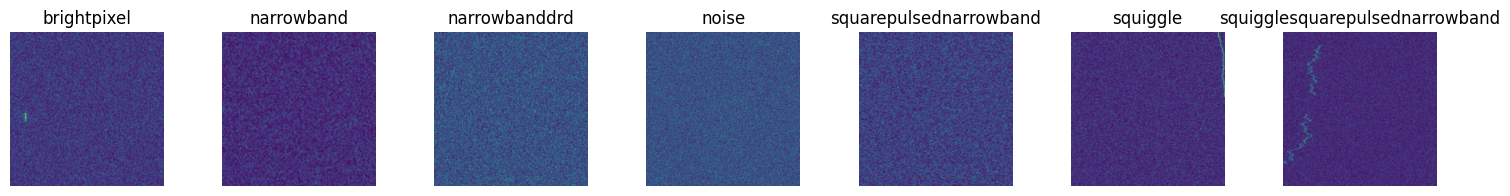

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-d

Epoch 0/49
----------
Train Loss: 1.1186 Acc: 0.5857 F1: 0.5775
Validation Loss: 0.5843 Acc: 0.7957 F1: 0.7970
Epoch 1/49
----------
Train Loss: 0.8949 Acc: 0.6654 F1: 0.6614
Validation Loss: 0.4896 Acc: 0.8300 F1: 0.8280
Epoch 2/49
----------
Train Loss: 0.8698 Acc: 0.6743 F1: 0.6703
Validation Loss: 0.5006 Acc: 0.8171 F1: 0.8175
Epoch 3/49
----------
Train Loss: 0.8163 Acc: 0.6995 F1: 0.6965
Validation Loss: 0.4964 Acc: 0.8429 F1: 0.8439
Epoch 4/49
----------
Train Loss: 0.8188 Acc: 0.6984 F1: 0.6966
Validation Loss: 0.4042 Acc: 0.8600 F1: 0.8613
Epoch 5/49
----------
Train Loss: 0.7919 Acc: 0.7102 F1: 0.7081
Validation Loss: 0.4192 Acc: 0.8657 F1: 0.8652
Epoch 6/49
----------
Train Loss: 0.8075 Acc: 0.7063 F1: 0.7060
Validation Loss: 0.3956 Acc: 0.8729 F1: 0.8740
Epoch 7/49
----------
Train Loss: 0.7748 Acc: 0.7139 F1: 0.7130
Validation Loss: 0.4064 Acc: 0.8643 F1: 0.8643
Epoch 8/49
----------
Train Loss: 0.7701 Acc: 0.7127 F1: 0.7121
Validation Loss: 0.3405 Acc: 0.8971 F1: 0.8985
E

In [4]:
# Accuracy 95%

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np

# 1. Define Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 2. Load Datasets
data_dir = '/kaggle/input/seti-data/primary_small'  # Adjust this path to your dataset
image_datasets = {
    'train': datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=data_transforms['train']),
    'valid': datasets.ImageFolder(root=os.path.join(data_dir, 'valid'), transform=data_transforms['valid']),
    'test': datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=data_transforms['test']),
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

# Check number of classes
num_classes = len(image_datasets['train'].classes)
print(f'Number of classes: {num_classes}')

# 3. Display a Single Random Image from Each Class in the Training Dataset
def show_random_images(dataset, class_names):
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 2))

    for i, cls in enumerate(class_names):
        # Filter images by class
        class_indices = [idx for idx in range(len(dataset)) if dataset.targets[idx] == i]
        
        # Randomly select one image from the class
        random_idx = np.random.choice(class_indices)
        image, _ = dataset[random_idx]

        # Un-normalize and plot the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        axs[i].imshow(image)
        axs[i].set_title(class_names[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from each class in the training dataset
class_names = image_datasets['train'].classes
print("Displaying a single random image from each class in the training dataset:")
show_random_images(image_datasets['train'], class_names)

# 4. Combine ResNet-50 and Inception-ResNet-V2
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs_resnet = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove final fully connected layer
        
        self.inception = models.inception_v3(pretrained=True, aux_logits=True)
        num_ftrs_inception = self.inception.fc.in_features
        self.inception.fc = nn.Identity()  # Remove final fully connected layer
        
        self.fc1 = nn.Linear(num_ftrs_resnet + num_ftrs_inception, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        resnet_features = self.resnet(x)
        inception_features = self.inception(x)
        
        if isinstance(inception_features, tuple):
            inception_features = inception_features[0]  # Take the first element if it's a tuple
        
        combined_features = torch.cat((resnet_features, inception_features), dim=1)
        x = torch.relu(self.fc1(combined_features))
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CombinedModel(num_classes)
model = model.to(device)

# 5. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

        # Validate the model
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss /= len(dataloaders['valid'].dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}')

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, num_epochs=50)

# 6. Evaluate the Model
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    class_report = classification_report(all_labels, all_preds, target_names=class_names)

    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

# Get class names from the dataset
class_names = image_datasets['test'].classes
evaluate_model(model, dataloaders['test'], class_names)

# Save the best model weights
torch.save(best_model_wts, 'combined_model.pth')

# Transfer-Learning using PyTorch

> ### **Models Used:** ResNet50, InceptionV4

Number of classes: 7
Displaying a single random image from each class in the training dataset:


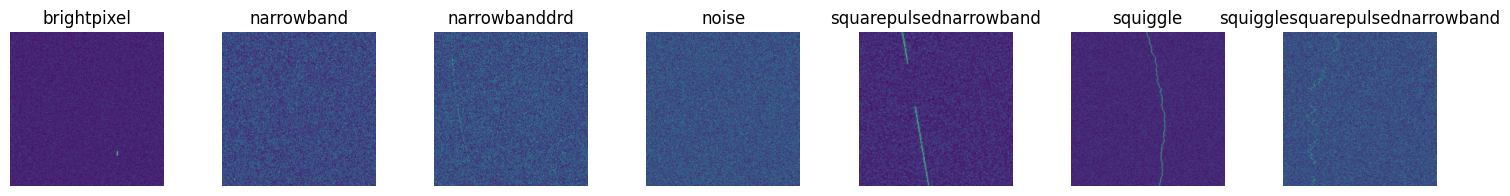

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Epoch 0/49
----------
Train Loss: 1.1367 Acc: 0.5677 F1: 0.5597
Validation Loss: 0.8381 Acc: 0.7129 F1: 0.7116
Epoch 1/49
----------
Train Loss: 0.9744 Acc: 0.6264 F1: 0.6194
Validation Loss: 0.6071 Acc: 0.7886 F1: 0.7722
Epoch 2/49
----------


KeyboardInterrupt: 

In [1]:
# Accuracy 94%

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from timm import create_model

# 1. Define Transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 2. Load Datasets
data_dir = '/kaggle/input/seti-data/primary_small'  # Adjust this path to your dataset
image_datasets = {
    'train': datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=data_transforms['train']),
    'valid': datasets.ImageFolder(root=os.path.join(data_dir, 'valid'), transform=data_transforms['valid']),
    'test': datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=data_transforms['test']),
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4),
}

# Check number of classes
num_classes = len(image_datasets['train'].classes)
print(f'Number of classes: {num_classes}')

# 3. Display a Single Random Image from Each Class in the Training Dataset
def show_random_images(dataset, class_names):
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 2))

    for i, cls in enumerate(class_names):
        # Filter images by class
        class_indices = [idx for idx in range(len(dataset)) if dataset.targets[idx] == i]
        
        # Randomly select one image from the class
        random_idx = np.random.choice(class_indices)
        image, _ = dataset[random_idx]

        # Un-normalize and plot the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        axs[i].imshow(image)
        axs[i].set_title(class_names[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display random images from each class in the training dataset
class_names = image_datasets['train'].classes
print("Displaying a single random image from each class in the training dataset:")
show_random_images(image_datasets['train'], class_names)

# 4. Combine ResNet-50 and Inception v4
class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs_resnet = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # Remove final fully connected layer
        
        self.inception_v4 = create_model('inception_v4', pretrained=True)
        num_ftrs_inception_v4 = self.inception_v4.get_classifier().in_features
        self.inception_v4.reset_classifier(0)  # Remove final fully connected layer
        
        self.fc1 = nn.Linear(num_ftrs_resnet + num_ftrs_inception_v4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        resnet_features = self.resnet(x)
        inception_v4_features = self.inception_v4(x)
        
        combined_features = torch.cat((resnet_features, inception_v4_features), dim=1)
        x = torch.relu(self.fc1(combined_features))
        x = self.fc2(x)
        
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CombinedModel(num_classes)
model = model.to(device)

# 5. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

def train_model(model, criterion, optimizer, scheduler, num_epochs=50):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

        # Validate the model
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for inputs, labels in dataloaders['valid']:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        val_loss /= len(dataloaders['valid'].dataset)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='weighted')

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}')

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # deep copy the model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model = train_model(model, criterion, optimizer, scheduler, num_epochs=50)

# 6. Evaluate the Model
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    class_report = classification_report(all_labels, all_preds, target_names=class_names)

    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test F1 Score: {f1:.4f}')
    print('Classification Report:')
    print(class_report)

# Get class names from the dataset
class_names = image_datasets['test'].classes
evaluate_model(model, dataloaders['test'], class_names)

# Save the best model weights
torch.save(best_model_wts, 'combined_model.pth')

# Generated Combined Model Tester

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np

class CombinedModel(nn.Module):
    def __init__(self, num_classes):
        super(CombinedModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs_resnet = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        
        self.inception_resnet = models.inception_v3(pretrained=True, aux_logits=True)
        num_ftrs_inception_resnet = self.inception_resnet.fc.in_features
        self.inception_resnet.fc = nn.Identity()
        
        self.fc1 = nn.Linear(num_ftrs_resnet + num_ftrs_inception_resnet, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        resnet_features = self.resnet(x)
        inception_resnet_features = self.inception_resnet(x)
        
        if isinstance(inception_resnet_features, tuple):
            inception_resnet_features = inception_resnet_features[0]
        
        combined_features = torch.cat((resnet_features, inception_resnet_features), dim=1)
        x = torch.relu(self.fc1(combined_features))
        x = self.fc2(x)
        
        return x

# Load the model
num_classes = 7  # Replace with the actual number of classes
model = CombinedModel(num_classes)
model.load_state_dict(torch.load('/kaggle/working/combined_model.pth'))
model = model.to('cuda:0' if torch.cuda.is_available() else 'cpu')
model.eval()

# Define transformations
data_transforms = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define class names
class_names = ['brightpixel', 'narrowband', 'narrowbanddrd', 'noise', 'squarepulsednarrowband', 'squiggle', 'squigglesquarepulsednarrowband']  # Replace with actual class names

def predict(image, model, transform, class_names):
    image = transform(image).unsqueeze(0).to('cuda:0' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        pred_class = class_names[preds[0]]

    return pred_class

# Example usage
image_path = '/kaggle/input/seti-data/primary_small/train/squarepulsednarrowband/1005_squarepulsednarrowband.png'
image = Image.open(image_path).convert('RGB')
prediction = predict(image, model, data_transforms, class_names)
print(f'Predicted class: {prediction}')

Predicted class: squarepulsednarrowband
